<a href="https://colab.research.google.com/github/alishahmad/cove/blob/master/%5BSTUDENT%5D_Module_2_Introduction_to_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.exceptions import NotFittedError
sns.set_style('whitegrid')

import geopandas as gpd
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.random.set_seed(42)

## Data Ingestion

In [3]:
vehicle_df = pd.read_csv("/content/car details v4.csv")

## Data Preprocessing Class from Module 1

In [4]:
class Preprocessor:
    def __init__(self, X_train):
        self.X_train = X_train
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.imputer = KNNImputer(n_neighbors=1)
        self.max_age = self.X_train['Year'].max()


    def preprocess(self, X):
        # Create a copy of X to avoid modifying the original DataFrame

        X_processed = X.copy()
        num_cols = X.select_dtypes(include=np.number).columns
        cat_cols = X.select_dtypes(include=object).columns

        X_processed['LogPrice'] = np.log(X_processed['Price'])
        X_processed.drop(['Price'], inplace=True, axis=1)
        # Age Feature
        age = self.max_age - X_processed['Year']
        X_processed.insert(3, column='Age', value=age)
        X_processed.drop(['Year'], axis=1, inplace=True)

        # Car Volume Feature
        X_processed['Volume'] = X_processed['Length'] * X_processed['Height'] * X_processed['Width']

        # Max Power Feature
        max_bhp = X_processed['Max Power'].str.split(pat='@').str[0].str.split(pat=" ").str[0]
        max_rpm = X_processed['Max Power'].str.split(pat='@').str[1].str.split(pat=" ").str[1]
        vehicle_max_power_df = pd.DataFrame({'Max_Power_BHP': max_bhp, 'Max_Power_RPM': max_rpm})

        # Max Torque Feature
        max_bhp = X_processed['Max Torque'].str.split(pat='@').str[0].str.split(pat=" ").str[0]
        max_rpm = X_processed['Max Torque'].str.split(pat='@').str[1].str.split(pat=" ").str[1]
        vehicle_max_torque_df = pd.DataFrame({'Max_Torque_BHP': max_bhp, 'Max_Torque_RPM': max_rpm})

        # CC Feature
        cc = X_processed['Engine'].str.split(pat=" ").str[0]
        vehicle_cc_df = pd.DataFrame({'CC': cc})

        X_processed = pd.concat((X_processed, vehicle_max_power_df, vehicle_max_torque_df, vehicle_cc_df), axis=1)
        X_processed.drop(['Max Power', 'Max Torque', 'Engine'], axis=1, inplace=True)

        cat_cols = X_processed.select_dtypes(include=object).columns
        num_cols = X_processed.select_dtypes(include=np.number).columns

        # Convert specified columns to int64, handling potential errors
        for column in ['Max_Power_BHP', 'Max_Power_RPM', 'Max_Torque_BHP', 'Max_Torque_RPM', 'CC']:
          try:
            # Convert to numeric, coerce errors to NaN, fill NaN with 0, and then convert to Int64
            X_processed[column] = pd.to_numeric(X_processed[column], errors='coerce').fillna(0).astype(int)
          except KeyError:
            print(f"Column '{column}' not found in DataFrame.")


        # Scaling Numerical Values
        X_processed['Kilometer'] = X_processed['Kilometer'] / 10000
        X_processed['Length'] = X_processed['Length'] / 1000
        X_processed['Width'] = X_processed['Width'] / 1000
        X_processed['Height'] = X_processed['Height'] / 1000
        X_processed['Fuel Tank Capacity'] = X_processed['Fuel Tank Capacity'] / 10
        X_processed['Max_Power_BHP'] = X_processed['Max_Power_BHP'] / 100
        X_processed['Max_Power_RPM'] = X_processed['Max_Power_RPM'] / 1000
        X_processed['Max_Torque_BHP'] = X_processed['Max_Torque_BHP'] / 100
        X_processed['Max_Torque_RPM'] = X_processed['Max_Torque_RPM'] / 1000
        X_processed['CC'] = X_processed['CC'] / 1000

        # Encoding Categorical Attributes
        try:
          encoded_data = self.encoder.transform(X_processed[cat_cols])
        except NotFittedError:
          encoded_data = self.encoder.fit_transform(X_processed[cat_cols])
        cat_encoded_df = pd.DataFrame(encoded_data, columns=self.encoder.get_feature_names_out(cat_cols))
        X_processed_encoded_df = pd.concat([X_processed[num_cols].reset_index(drop=True), cat_encoded_df.reset_index(drop=True)], axis=1, ignore_index=True)

        num_cols_list = X_processed[num_cols].columns.to_list()
        cat_cols_list = cat_encoded_df.columns.to_list()
        all_columns = num_cols_list + cat_cols_list

        X_processed_encoded_df.columns = all_columns

        # Handling Missing Values
        X_processed_encoded_no_na = self.imputer.fit_transform(X_processed_encoded_df)
        X_processed_encoded_no_na_df = pd.DataFrame(X_processed_encoded_no_na, columns=all_columns)

        y = X_processed_encoded_no_na_df['LogPrice']
        X_processed_encoded_no_na_df.drop(['LogPrice'], axis=1, inplace=True)
        X = X_processed_encoded_no_na_df.to_numpy()
        intercept = np.ones((X.shape[0], 1))
        X = np.c_[X, intercept]

        return X, y

In [5]:
from sklearn.model_selection import train_test_split

# Assuming 'vehicle_df' is your DataFrame and you want to stratify based on 'fuel' column
# Replace 'fuel' with your desired non-numerical column for stratification

# Get value counts for the stratify columns
stratify_counts = vehicle_df.groupby(['Make', 'Location']).size()

# Filter out combinations with less than 2 samples
valid_stratify_indices = stratify_counts[stratify_counts >= 2].index

# Filter the DataFrame to include only valid combinations
filtered_df = vehicle_df[vehicle_df.set_index(['Make', 'Location']).index.isin(valid_stratify_indices)]

# Perform train-test split on the filtered DataFrame
X_train, X_test = train_test_split(
    filtered_df, test_size=0.3, stratify=filtered_df[['Make','Location']], random_state=42
)

In [6]:
preprocessor = Preprocessor(X_train)

In [7]:
X_np, y_np = preprocessor.preprocess(X_train)

In [8]:
X_test_np, y_test_np = preprocessor.preprocess(X_test)

# Basic Neural Network Structure

Benchmark MSE : 0.06546436028596885

In [9]:
dims = X_np.shape[1]

A neural network with 2 hidden layers.



1.   Input layer equal to the number of features dims.
2.   First hidden layer with 64 neurons.
3.Second hidden layer with 32 neurons.
4. Output layer with one neurons





In [11]:
model = tf.keras.Sequential([
tf.keras.layers.Dense(64, activation='relu', input_shape=(dims,)),
tf.keras.layers.Dense(32, activation='relu'),
tf.keras.layers.Dense(1)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile and train the neural network

In [13]:

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Train the model
history = model.fit(X_np, y_np, epochs=100) # Adjust epochs and batch_size as needed


# Evaluate the model
loss, mae = model.evaluate(X_test_np, y_test_np, verbose=0)
print(f"Mean Absolute Error: {mae}")

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 89058723862937600.0000 - mse: 89058723862937600.0000  
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 956809930080256.0000 - mse: 956809930080256.0000
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18798117650432.0000 - mse: 18798117650432.0000
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 177009655808.0000 - mse: 177009655808.0000
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2881906944.0000 - mse: 2881906944.0000
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80861544.0000 - mse: 80861544.0000
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 664282.3125 - mse: 664282.3125
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12195.8662 - mse: 12195.8662
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2994.7722 - mse: 2994.7722
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2702.0256 - mse: 2702.0256
Epoch 11/100
40/40 ━━━━━━━━

In [ ]:
history = history.history

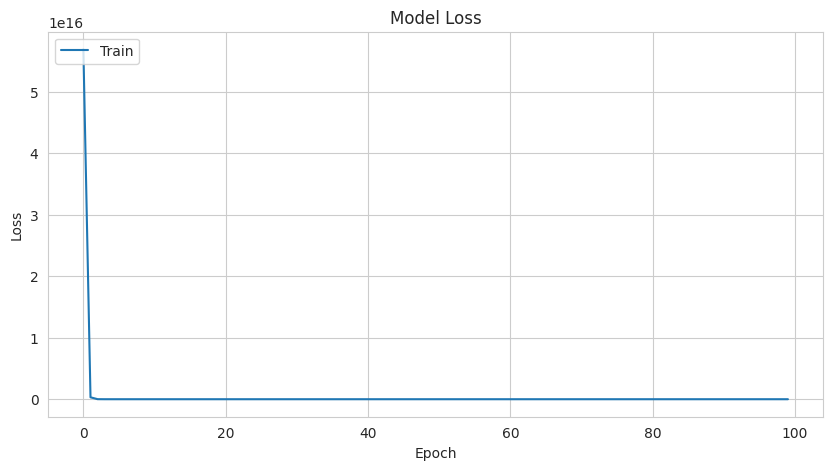

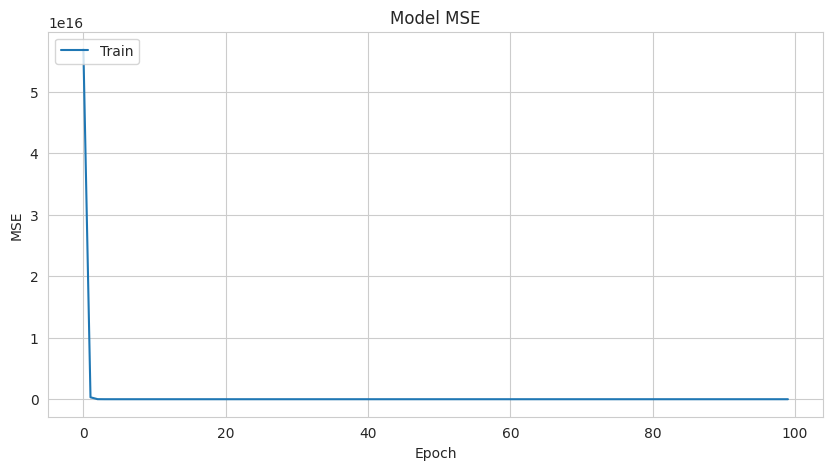

In [ ]:
# prompt: Create a training plot from the previous neural network training
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history['loss'])
# plt.plot(history['val_loss']) # Uncomment if you have validation data
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left') # Adjust legend if you have validation data
plt.show()

# Plot training & validation MSE values (if available)
plt.figure(figsize=(10, 5))
plt.plot(history['mse'])
# plt.plot(history['val_mse']) # Uncomment if you have validation data and MSE in history
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left') # Adjust legend if you have validation data
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
y_pred = model.predict(X_np)
r2 = r2_score(y_np, y_pred)
mse = mean_squared_error(y_np, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R-squared: -902.3543472904661
Mean Squared Error: 841.9180916944188


In [ ]:
y_test_pred = model.predict(X_test_np)
r2 = r2_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
R-squared: -803.8759868695463
Mean Squared Error: 790.9335667936963


## Improving the Neural Network - Add More Neurons

A neural network with four hidden layers.

1. One input layer equal to the number of features.
2. First hidden layer with 256 nuerons.
3. Second hidden layer with 128 neurons.
4. Third hidden layer with 64 neurons.
5. Fourth hidden layer with 32 neurons.
6. Output layer with one neurons.

In [15]:
#deeper and wider deep learning model
model = tf.keras.Sequential([
tf.keras.layers.Dense(256, activation='relu', input_shape=(dims,)),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(32, activation='relu'),
tf.keras.layers.Dense(1)
])


In [18]:
# Compile the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mse']) # Added compile step
# Train the model
history = model.fit(X_np, y_np, epochs=100)

# Evaluate the model
loss, mae = model.evaluate(X_test_np, y_test_np, verbose=0)
print(f"Mean Absolute Error: {mae}")

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6838557524099072.0000 - mse: 6838557524099072.0000
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10571548196864.0000 - mse: 10571548196864.0000
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 187661074432.0000 - mse: 187661074432.0000
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4116046080.0000 - mse: 4116046080.0000
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 92428240.0000 - mse: 92428240.0000  
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1187325.1250 - mse: 1187325.1250
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19179.3281 - mse: 19179.3281
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1296.2748 - mse: 1296.2748
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 789.2057 - mse: 789.2057
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 797.9934 - mse: 797.9934
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/ste

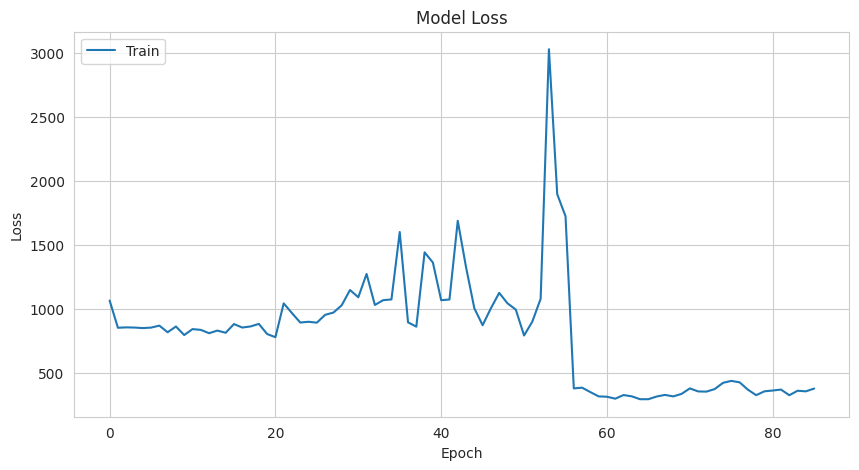

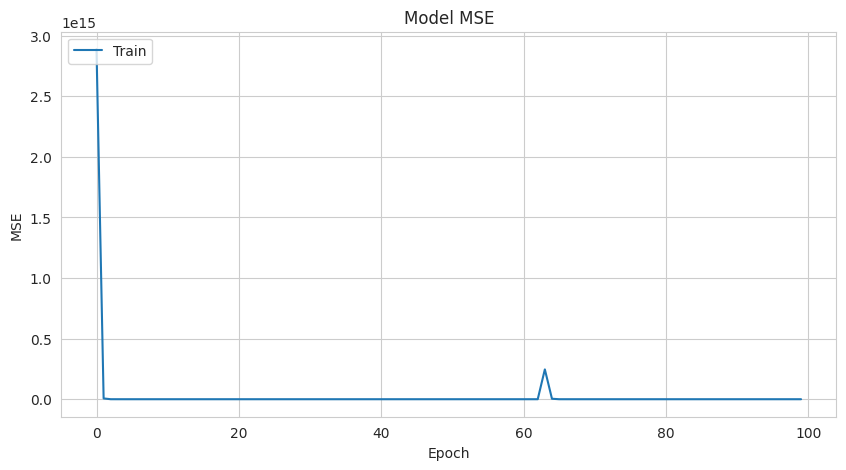

In [19]:
history = history.history
loss =  np.array(history["loss"])
loss = loss[~(np.array(history["loss"]) > 5000)]
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(loss)
# plt.plot(history['val_loss']) # Uncomment if you have validation data
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left') # Adjust legend if you have validation data
plt.show()

# Plot training & validation MSE values (if available)
plt.figure(figsize=(10, 5))
plt.plot(history['mse'])
# plt.plot(history['val_mse']) # Uncomment if you have validation data and MSE in history
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left') # Adjust legend if you have validation data
plt.show()

In [21]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(X_np)
r2 = r2_score(y_np, y_pred)
mse = mean_squared_error(y_np, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

#y_pred = model.predict(X_np)
#r2 = r2_score(y_np, y_pred)
#mse = mean_squared_error(y_np, y_pred)

#print("R-squared:", r2)
#print("Mean Squared Error:", mse)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R-squared: -421.86251959617397
Mean Squared Error: 394.1040485556336


In [22]:
y_test_pred = model.predict(X_test_np)
r2 = r2_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R-squared: -409.66893525606633
Mean Squared Error: 403.55514518051507


## Preventing Exploding/Vanishing Gradients

### Using a better Activation Function

In [25]:
# Use the Gelu Activation Function
model = tf.keras.Sequential([
tf.keras.layers.Dense(256, activation='gelu', input_shape=(dims,)),
tf.keras.layers.Dense(128, activation='gelu'),
tf.keras.layers.Dense(64, activation='gelu'),
tf.keras.layers.Dense(32, activation='gelu'),
tf.keras.layers.Dense(1)
])


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Train the model
history = model.fit(X_np, y_np, batch_size=32, epochs=100) # Adjust epochs and batch_size as needed


# Evaluate the model
loss, mae = model.evaluate(X_test_np, y_test_np, verbose=0)
print(f"Mean Absolute Error: {mae}")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 4278193569660928.0000 - mse: 4278193569660928.0000
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5829206.5000 - mse: 5829206.5000
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3923.9771 - mse: 3923.9771
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2990.5930 - mse: 2990.5930
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2596.5259 - mse: 2596.5259
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2519.4526 - mse: 2519.4526
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2513.5259 - mse: 2513.5259
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2366.5034 - mse: 2366.5034
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2889.3721 - mse: 2889.3721
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2421.0283 - mse: 2421.0283
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2505.1265 - mse: 2505.1265
Epoch 12/100
40/4

In [26]:
history = history.history

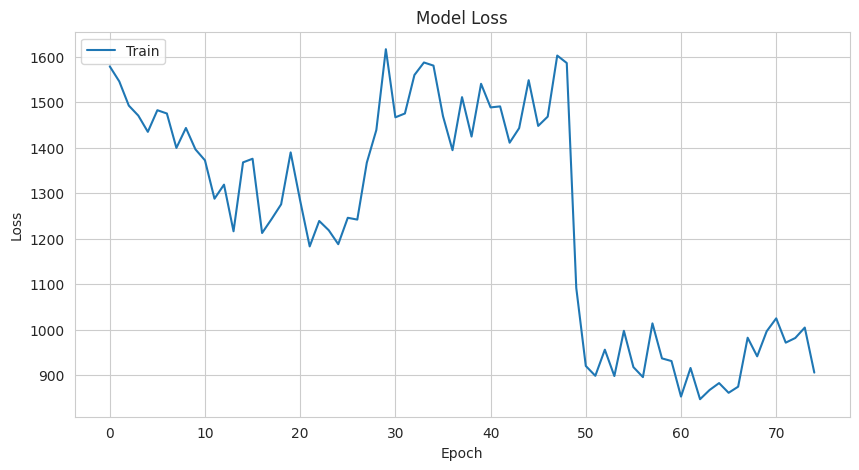

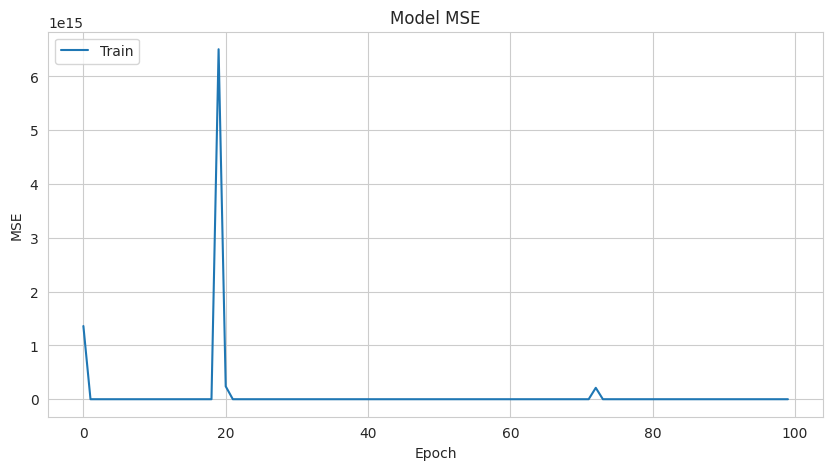

In [27]:
loss =  np.array(history["loss"])
loss = loss[~(np.array(history["loss"]) > 2000)]
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(loss)
# plt.plot(history['val_loss']) # Uncomment if you have validation data
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left') # Adjust legend if you have validation data
plt.show()

# Plot training & validation MSE values (if available)
plt.figure(figsize=(10, 5))
plt.plot(history['mse'])
# plt.plot(history['val_mse']) # Uncomment if you have validation data and MSE in history
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left') # Adjust legend if you have validation data
plt.show()

In [28]:
y_pred = model.predict(X_np)
r2 = r2_score(y_np, y_pred)
mse = mean_squared_error(y_np, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R-squared: -844.3863922136497
Mean Squared Error: 787.8924811861114


In [29]:
y_test_pred = model.predict(X_test_np)
r2 = r2_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R-squared: -865.0242773536124
Mean Squared Error: 851.0226193743373


### Using a Different Initialization Function

In [36]:
# Use the Truncated Normal Initialization

ke = 'truncated_normal'
model = tf.keras.Sequential([
tf.keras.layers.Dense(256, activation='gelu', kernel_initializer=ke, input_shape=(dims,)),
tf.keras.layers.Dense(128, activation='gelu', kernel_initializer=ke),
tf.keras.layers.Dense(64, activation='gelu',  kernel_initializer=ke),
tf.keras.layers.Dense(32, activation='gelu',    kernel_initializer=ke),
tf.keras.layers.Dense(1,)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Train the model
history = model.fit(X_np, y_np, batch_size=32, epochs=100) # Adjust epochs and batch_size as needed


# Evaluate the model
loss, mae = model.evaluate(X_test_np, y_test_np, verbose=0)
print(f"Mean Absolute Error: {mae}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 59214055604224.0000 - mse: 59214055604224.0000
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2373539328.0000 - mse: 2373539328.0000
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 28.7164 - mse: 28.7164
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 28.6078 - mse: 28.6078
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 18.3977 - mse: 18.3977
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 18.2094 - mse: 18.2094
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 18.4358 - mse: 18.4358
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17.2102 - mse: 17.2102
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 18.1051 - mse: 18.1051
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17.5808 - mse: 17.5808
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 15.4534 - mse: 15.4534
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11

In [37]:
history = history.history

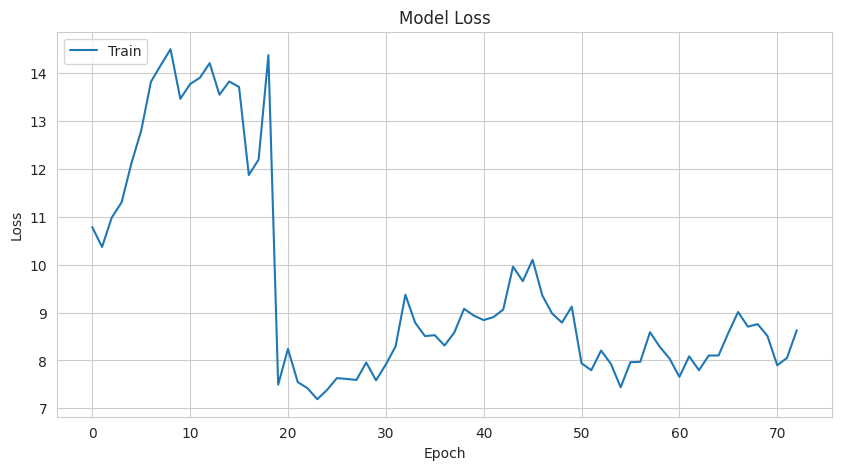

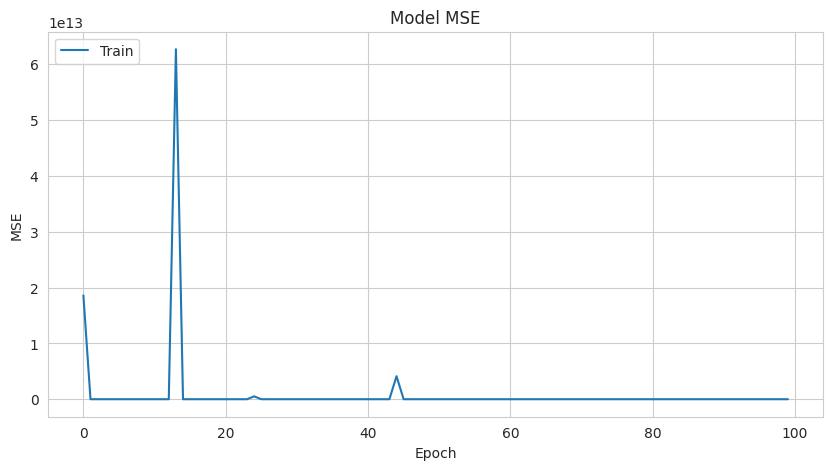

In [38]:
loss =  np.array(history["loss"])
loss = loss[~(np.array(history["loss"]) > 15)]
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(loss)
# plt.plot(history['val_loss']) # Uncomment if you have validation data
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left') # Adjust legend if you have validation data
plt.show()

# Plot training & validation MSE values (if available)
plt.figure(figsize=(10, 5))
plt.plot(history['mse'])
# plt.plot(history['val_mse']) # Uncomment if you have validation data and MSE in history
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left') # Adjust legend if you have validation data
plt.show()

In [39]:
y_pred = model.predict(X_np)
r2 = r2_score(y_np, y_pred)
mse = mean_squared_error(y_np, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R-squared: -17.92207983982622
Mean Squared Error: 17.63520748797979


In [40]:
y_test_pred = model.predict(X_test_np)
r2 = r2_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R-squared: -17.60776843141266
Mean Squared Error: 18.285436384765397


### Using Layer and Batch Normalization

In [50]:
# Use the layer normalization


model = tf.keras.Sequential([

])
ke = 'truncated_normal'
model = tf.keras.Sequential([
tf.keras.layers.Dense(256, activation='gelu', kernel_initializer=ke, input_shape=(dims,)),
tf.keras.layers.LayerNormalization(),

tf.keras.layers.Dense(128, activation='gelu', kernel_initializer=ke),
tf.keras.layers.LayerNormalization(),

tf.keras.layers.Dense(64, activation='gelu',  kernel_initializer=ke),
tf.keras.layers.LayerNormalization(),

tf.keras.layers.Dense(32, activation='gelu',    kernel_initializer=ke),
tf.keras.layers.LayerNormalization(),

tf.keras.layers.Dense(1)
])



# Compile the model
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Train the model
model.fit(X_np, y_np, epochs=100) # Adjust epochs and batch_size as needed


# Evaluate the model
loss, mae = model.evaluate(X_test_np, y_test_np, verbose=0)
print(f"Mean Absolute Error: {mae}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 64.0474 - mse: 64.0474
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17.3901 - mse: 17.3901
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.2789 - mse: 7.2789
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5664 - mse: 2.5664
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1137 - mse: 1.1137
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8536 - mse: 0.8536
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8372 - mse: 0.8372
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8416 - mse: 0.8416
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8434 - mse: 0.8434
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8439 - mse: 0.8439
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8441 - mse: 0.8441
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8442 - mse: 0.8442
Epoch 13/100
40/40 ━━━━━━━

In [51]:
y_pred = model.predict(X_np)
r2 = r2_score(y_np, y_pred)
mse = mean_squared_error(y_np, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R-squared: -0.002675279310807799
Mean Squared Error: 0.9344843031735448


In [52]:
y_test_pred = model.predict(X_test_np)
r2 = r2_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R-squared: -0.001327827957625205
Mean Squared Error: 0.9839823816543719


In [53]:
# Use the batch normalization
model = tf.keras.Sequential([

])
ke = 'truncated_normal'
model = tf.keras.Sequential([
tf.keras.layers.Dense(256, activation='gelu', kernel_initializer=ke, input_shape=(dims,)),

tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(128, activation='gelu', kernel_initializer=ke),

tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(64, activation='gelu',  kernel_initializer=ke),

tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(32, activation='gelu',    kernel_initializer=ke),

tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(1)
])


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# Train the model
model.fit(X_np, y_np, epochs=100) # Adjust epochs and batch_size as needed


# Evaluate the model
loss, mae = model.evaluate(X_test_np, y_test_np, verbose=0)
print(f"Mean Absolute Error: {mae}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 187.8445 - mse: 187.8445
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 178.2693 - mse: 178.2693
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 164.6942 - mse: 164.6942
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 146.1835 - mse: 146.1835
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 123.9107 - mse: 123.9107
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 99.7126 - mse: 99.7126
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 75.6779 - mse: 75.6779
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 53.7802 - mse: 53.7802
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 35.5141 - mse: 35.5141
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 21.6177 - mse: 21.6177
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12.0920 - mse: 12.0920
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2278 - mse: 6.2278
E

In [54]:
y_pred = model.predict(X_np)
r2 = r2_score(y_np, y_pred)
mse = mean_squared_error(y_np, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
R-squared: 0.5316923374620269
Mean Squared Error: 0.4364585112723963


In [ ]:
y_test_pred = model.predict(X_test_np)
r2 = r2_score(y_test_np, y_test_pred)
mse = mean_squared_error(y_test_np, y_test_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

## Classification - Fashion MNIST



In [55]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [56]:
classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

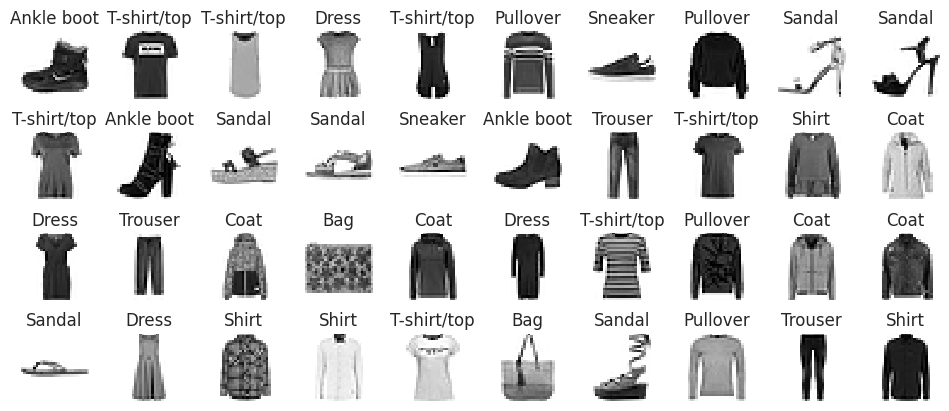

In [57]:
# extra code – this cell generates and saves Figure 10–10
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(classes[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.savefig('fashion_mnist.png')
plt.show()


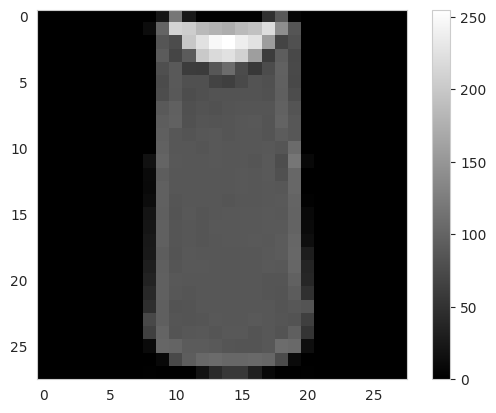

In [58]:
# prompt: Create a plot for one of the fashion mnist dataset

# Display a sample image from the Fashion MNIST dataset
plt.figure()
plt.imshow(X_train[2], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

In [59]:
#normalize the features
X_train,  X_test = X_train / 255., X_test / 255.

A neural network with 2 hidden layers.

1. Input layer equal to the number of pixels. 28 x 28.
2. First hidden layer with 300 neurons.
3. Second hidden layer with 100 neurons.
4. Output layer equal to the number of classes, with softmax activation function.

In [64]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu'),
     tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
#compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [67]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7867 - loss: 0.6046 - val_accuracy: 0.8548 - val_loss: 0.4008
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8637 - loss: 0.3705 - val_accuracy: 0.8612 - val_loss: 0.3779
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8776 - loss: 0.3284 - val_accuracy: 0.8699 - val_loss: 0.3587
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8866 - loss: 0.3013 - val_accuracy: 0.8698 - val_loss: 0.3598
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8932 - loss: 0.2799 - val_accuracy: 0.8732 - val_loss: 0.3627
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8986 - loss: 0.2635 - val_accuracy: 0.8698 - val_loss: 0.3633
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9038 - loss: 0.2503 - val_accuracy: 0.8734 - val_loss: 0.3524
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9081 - loss: 0

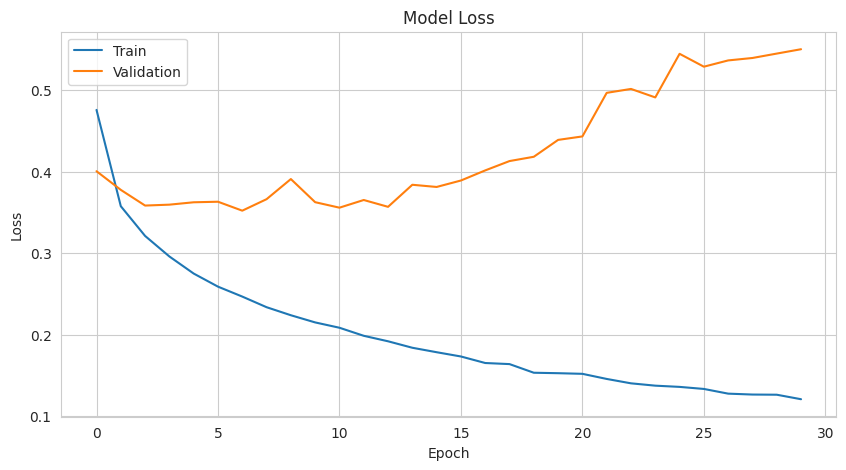

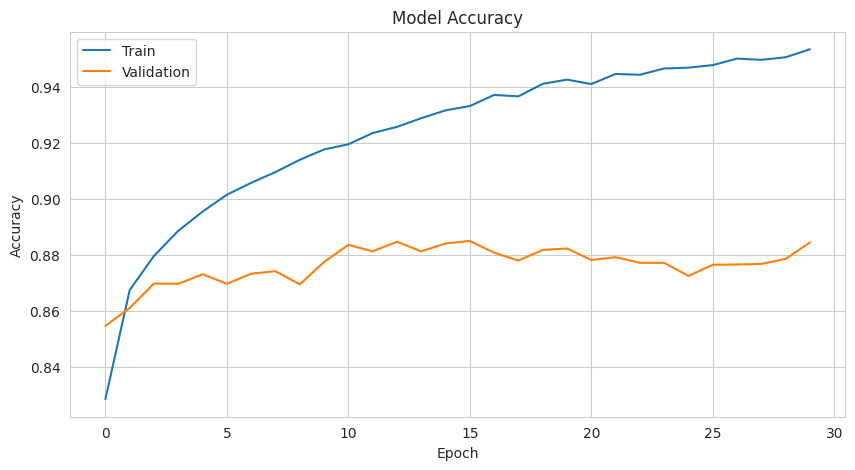

In [68]:
# prompt: plot training plot

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()